In [60]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset
%matplotlib inline

In [61]:
# Read data:

missing_values = ["n/a", "na", "NaN", "--", "null"]
df = pd.read_csv('data/CombinedMacroSectorv4.csv', sep=",", na_values = missing_values, index_col=None)
print(df.shape)

(4275, 22)


In [62]:
df.head()

,Date,Oil,Inflation,CPI,Dollar Index,GDP,Unemployment,Recession,Energy,Gold,...,Customer Discretionary,Consumer Staples,Health,Financials,Technology,Telecommunications,Utilities,Real Estate,Cycle,Spy
0,9/29/04,49.53,2.34,189.8,88.099998,3.8,5.4,0,34.720001,NaN,...,31.070000,21.610001,29.350000,23.176279,19.049999,22.680000,25.000000,49.849998,ExpandBeforePeak,129.00000
1,9/30/04,49.56,2.37,189.8,87.360001,3.8,5.4,0,34.930000,NaN,...,31.200001,21.660000,28.790001,23.119415,19.120001,22.620001,25.049999,50.250000,ExpandBeforePeak,130.09375
2,10/1/04,50.16,2.38,190.8,87.629997,4.1,5.5,0,35.430000,NaN,...,31.590000,21.879999,29.059999,23.509342,19.600000,22.990000,25.250000,51.180000,ExpandBeforePeak,129.43750
3,10/4/04,49.85,2.33,190.8,88.379997,4.1,5.5,0,35.389999,NaN,...,31.889999,21.830000,29.190001,23.541836,19.760000,23.309999,25.350000,51.400002,ExpandBeforePeak,127.81250
4,10/5/04,51.08,2.34,190.8,88.169998,4.1,5.5,0,35.770000,NaN,...,31.850000,21.830000,29.100000,23.411860,19.900000,23.400000,25.459999,51.389999,ExpandBeforePeak,130.12500


In [63]:
df['time'] = pd.to_datetime(df['Date'],utc=True)
df['time']= df.time.dt.tz_localize(None)
#df['Time'] = normalize(df)
#df['Class'] = df['Recession']
#std_normalize(["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
#"Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
#"Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"], df)
df.drop(['Date'], axis=1, inplace=True)
#df.drop(['Cycle'], axis=1, inplace=True)
#df.drop(['Gold'], axis=1, inplace=True)


#ts = scaler.fit_transform(
#    ts
#)  # scale the whole time series not caring about train/val split...

In [64]:
columns = ["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
"Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
"Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"]

series = TimeSeries.from_dataframe(df, 'time', ['Oil', "CPI", "Dollar Index"])

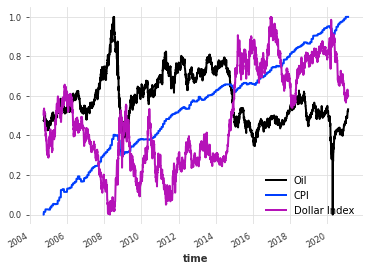

In [65]:
scaler = Scaler()
series_transformed = scaler.fit_transform(
    series
)  #scale the whole time series not caring about train/val split..

train, val =  series_transformed.split_after(pd.Timestamp('20170901'))
series_transformed.plot()

In [66]:
# We'll use the day as a covariate
day_series = datetime_attribute_timeseries(
    series_transformed, attribute="day", one_hot=True
)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("20170901"))

In [67]:
model = TCNModel(
    input_chunk_length=365,
    output_chunk_length=7,
    n_epochs=50,
    dropout=0.2,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=8,
    nr_epochs_val_period=1,
    random_state=0,
)

model.fit(
    series=train,
    val_series=val,
    verbose=True,
)

[2022-02-01 20:27:44,617] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-01 20:27:44,617] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-01 20:27:44,619] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-02-01 20:27:44,619] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-02-01 20:27:44,622] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-01 20:27:44,622] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

In [68]:
backtest = model.historical_forecasts(
    series=series_transformed,
    start=0.7,
    forecast_horizon=7,
    stride=10,
    retrain=False,
    verbose=True,
)

  0%|          | 0/128 [00:00<?, ?it/s]

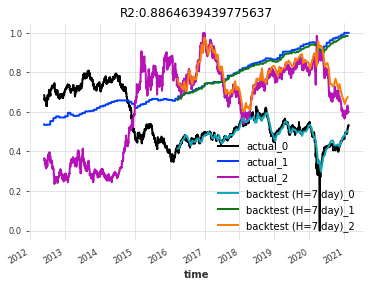

In [69]:
series_transformed[2000:].plot(label="actual")
backtest.plot(label="backtest (H=7 day)")
r2_score_value = r2_score(series_transformed, backtest)
plt.title('R2:' + str(r2_score_value))
plt.legend()